# Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import pingouin as pg
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap, ListedColormap
import matplotlib.patches as mpatches

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import classification_report
from sklearn.calibration import calibration_curve

#from imblearn.over_sampling import SMOTE
#from sklearn.preprocessing import PolynomialFeatures

# Preprocessing
- Load dataset
- Create new variables (one-hot-encoding) of answer 'Not aware of this option'
  - for column opinion_exercise
  - for column exercise_aware
- Replace values 'Not aware of this option' with imputed (means)

In [2]:
# Read dataset
df_raw_input = pd.read_excel("Assessment Part 3 dataset.xlsx", header=0)

# Drop first column
df = df_raw_input.drop(columns="a_a")

print(f"Loaded dataset with rows: {len(df)}")

#### Optinion exercise column

# replace 'Not aware of this option' with 'nan'
not_aware_exercise_bools = df["opinion_exercise"] == 0
df.loc[not_aware_exercise_bools, "opinion_exercise"] = np.nan

# Create new bool column capturing if they are aware of this option
df.insert(df.columns.get_loc("opinion_exercise") + 1, "exercise_aware", np.nan)
df["exercise_aware"] = (~not_aware_exercise_bools).astype(int)

#### Optinion diet column

# replace 'Not aware of this option' with 'nan'
not_aware_diet_bools = df["opinion_diet"] == 0
df.loc[not_aware_diet_bools, "opinion_diet"] = np.nan

# Create new bool column capturing if they are aware of this option
df.insert(df.columns.get_loc("opinion_diet") + 1, "diet_aware", np.nan)
df["diet_aware"] = (~not_aware_diet_bools).astype(int)


# Missing values
print("\nMissing values:")
missing_values_data = pd.DataFrame({
    'Column': df.columns,
    'NaN (count)': df.isna().sum().values,
    'NaN (%)': (df.isna().sum() / len(df) * 100).round(2).values
})[df.isna().sum().values > 0]

if len(missing_values_data) > 0:
    print(missing_values_data)
else:
    print("No missing values")


# Impute values
df.loc[not_aware_exercise_bools, "opinion_exercise"] = df.loc[~not_aware_exercise_bools, "opinion_exercise"].mean()
df.loc[not_aware_diet_bools, "opinion_diet"] = df.loc[~not_aware_diet_bools, "opinion_diet"].mean()
print("\nMissing values imputed using mean values")

print(f"\nWorking with dataset with rows: {len(df)}")

df

Loaded dataset with rows: 675

Missing values:
              Column  NaN (count)  NaN (%)
15  opinion_exercise           36     5.33
17      opinion_diet           20     2.96

Missing values imputed using mean values

Working with dataset with rows: 675


,health_satisfaction,body_ap_satisfaction,health_conciousness_1,health_conciousness_2,health_conciousness_3,health_conciousness_4,reduce_cost,convenience,environment,pay_more_eco,...,criterion_speed,criterion_maintenance,criterion_brand_name,criterion_ease_of_use,criterion_support,criterion_reviews,criterion_referrals,gender,age_group,Customer_brand_X
0,4,5,4,3,5,4,6,4,5,4,...,3,4,1,4,4,4,4,1,4,0
1,4,4,5,6,6,5,6,5,6,5,...,4,5,4,6,4,7,3,1,2,0
2,7,6,6,7,7,7,4,5,6,7,...,6,7,4,5,3,3,4,2,3,0
3,3,4,5,5,6,6,6,4,5,5,...,2,6,5,5,5,5,4,2,4,0
4,3,5,5,3,5,5,4,5,3,1,...,6,6,6,6,5,5,5,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,4,4,7,5,6,6,4,5,7,7,...,5,6,6,5,7,7,4,1,3,1
671,6,6,7,6,7,4,2,7,6,7,...,4,7,7,6,4,5,6,2,1,1
672,6,5,6,7,6,6,6,6,5,5,...,6,6,4,7,5,7,5,2,3,1
673,4,3,7,7,7,7,4,7,7,7,...,6,6,5,7,5,7,5,1,3,1


# VIF calculation
Definition of function for later use

In [3]:
def calculate_vif(df_vif: pd.DataFrame, print_any: bool = True) -> pd.DataFrame:

    # Calculate VIF for each feature
    df_vif = df_vif.drop(columns=["Customer_brand_X"])
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
    vif_data.sort_values(by="VIF", ascending=False, inplace=True)

    # Display VIF
    if print_any:
        print("\nVariation Inflation Factors:")
        print(vif_data)
    return vif_data

# Correlation matrix

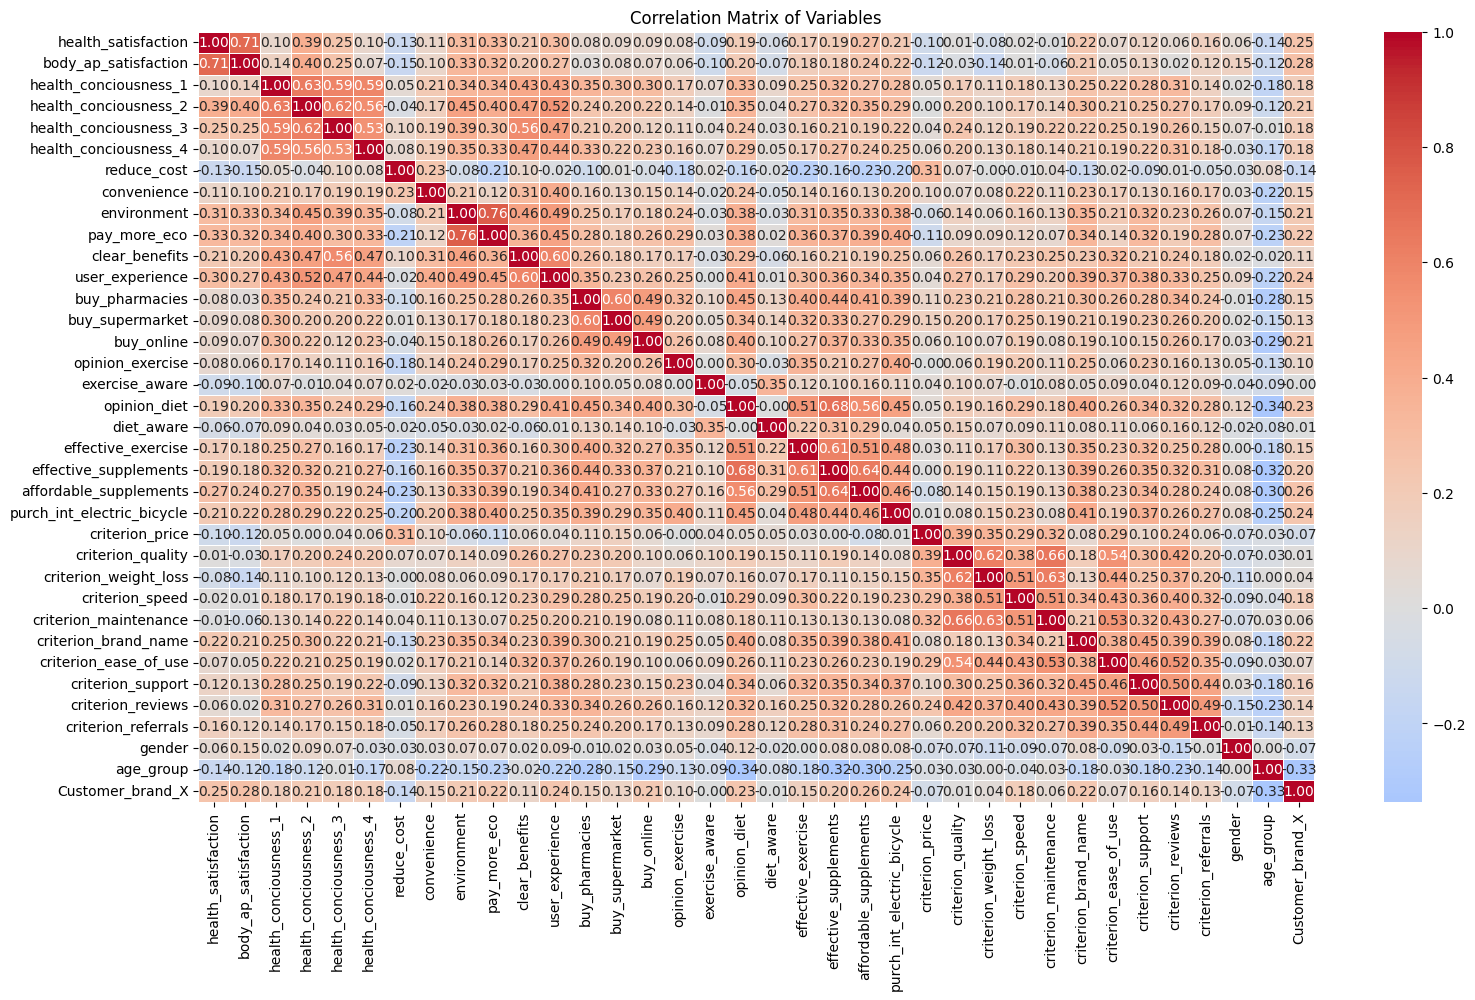

In [4]:
# Compute the correlation matrix
correlation_matrix = df.corr(method='pearson')

# Create a heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, center=0)
plt.title('Correlation Matrix of Variables')
plt.show()

# Define regression

In [5]:
from sklearn.model_selection import train_test_split

def logistic_regression(df_regression: pd.DataFrame, print_significant: bool = True, print_any = True) -> pd.DataFrame:

    # Define independent and dependent variables
    X = df_regression.drop(columns=["Customer_brand_X"])
    y = df_regression["Customer_brand_X"]
    
    # Apply SMOTE to rebalance the dataset (oversampling minority class)
    # smote = SMOTE(sampling_strategy='auto', random_state=1)

    # Apply polynomial features
    #poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    #X = poly.fit_transform(X)

    # Fit the logistic regression model using statsmodels
    logit_model = sm.Logit(y, X)
    result = logit_model.fit(disp=0)
    conf_int = result.conf_int()
    y_pred_probs = result.predict(X)
    y_pred_labels = (y_pred_probs >= 0.5).astype(int)

    # Get coefficients and p-values
    df_coefficients = pd.DataFrame({
        "Variables": X.columns,
        "Coefficients": result.params.round(2),
        "Effect %": ((np.exp(result.params) - 1) * 100).round(1),
        "P-values": result.pvalues.round(3),
        "CI Lower": conf_int[0].round(2),
        "CI Upper": conf_int[1].round(2)
    }).reset_index(drop=True)
    
    # Classification report
    report = classification_report(y, y_pred_labels)
    if print_any:
        print("Model Summary:\n", report)
    
    # McFadden's R-squared
    log_likelihood_model = result.llf # Log-likelihood of the fitted model
    log_likelihood_null = result.llnull # Log-likelihood of the null model (intercept-only model)
    mcfadden_r2 = 1 - (log_likelihood_model / log_likelihood_null)
    if print_any:
        print("McFadden's Pseudo R-squared:", round(mcfadden_r2, 4))

    # Coefficients
    if print_any:
        print("\nCoefficients:")
        print(df_coefficients)
        print()
    
    # Significant variables
    if print_significant and print_any:
        print("\n\nSignificant variables:")
        print(df_coefficients[df_coefficients["P-values"] < 0.05])


    df_predictions = pd.DataFrame({"y_actual": y, "y_pred_probs": y_pred_probs, "y_pred_label": y_pred_labels})

    #### Hosmer-Lemeshow Test

    # Define number of groups
    num_groups = 5

    # Create DataFrame with actual values and predicted probabilities
    hl_df = pd.DataFrame({"y_actual": y, "y_pred_probs": y_pred_probs})

    # Assign decile groups based on predicted probabilities
    hl_df["decile"] = pd.qcut(hl_df["y_pred_probs"], num_groups, labels=False)

    # Aggregate observed and expected counts per group
    hl_table = hl_df.groupby("decile").agg(
        observed_0=("y_actual", lambda x: (x == 0).sum()),
        observed_1=("y_actual", lambda x: (x == 1).sum()),
        expected_0=("y_pred_probs", lambda x: ((1 - x)).sum()),
        expected_1=("y_pred_probs", lambda x: x.sum())
    )

    # Small value to prevent division by zero
    hl_table["chi_square"] = ((hl_table["observed_0"] - hl_table["expected_0"])**2 / (hl_table["expected_0"] + 0)) + \
                            ((hl_table["observed_1"] - hl_table["expected_1"])**2 / (hl_table["expected_1"] + 0))

    # Compute HL test statistic
    hl_stat = hl_table["chi_square"].sum()

    # Compute p-value
    hl_p_value = 1 - stats.chi2.cdf(hl_stat, df=num_groups - 2)

    # Output results
    print(f"Hosmer-Lemeshow Test P-value: {hl_p_value:.3f}")

    return df_coefficients, df_predictions

# Construct model
Uses step-by-step method to remove variable one-by-one until all regresors are significant and have small VIF values



-----------------------------------
----- Iteration 1 -----
Model Summary:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       416
           1       0.67      0.59      0.63       259

    accuracy                           0.73       675
   macro avg       0.72      0.70      0.71       675
weighted avg       0.73      0.73      0.73       675

McFadden's Pseudo R-squared: 0.226

Coefficients:
                     Variables  Coefficients  Effect %  P-values  CI Lower  \
0          health_satisfaction          0.05       5.2     0.566     -0.12   
1         body_ap_satisfaction          0.27      30.4     0.001      0.10   
2        health_conciousness_1         -0.04      -3.5     0.743     -0.25   
3        health_conciousness_2         -0.11     -10.3     0.326     -0.33   
4        health_conciousness_3          0.28      32.7     0.015      0.06   
5        health_conciousness_4          0.15      16.4     0.119     -0.04   

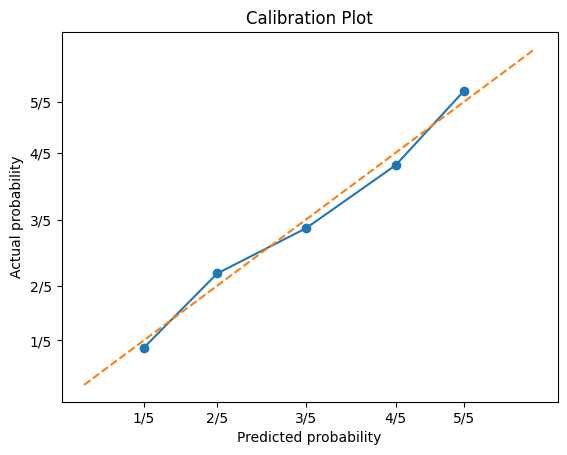

In [6]:
df_cleaned = df.copy(deep=True)

i = 0
while True:
    i = i + 1
    print("\n\n-----------------------------------")
    print(f"----- Iteration {i} -----")

    # Perform regression
    df_model, _ = logistic_regression(df_cleaned, print_any=True)
    
    # Ignore constant variable if present
    df_model = df_model[df_model['Variables'] != 'const'] 
    
    # Check p-values
    df_model.sort_values(by="P-values", inplace=True, ascending=False)
    highest_p_value = df_model.iloc[0]["P-values"]

    # Check VIF
    df_vif = calculate_vif(df_cleaned, print_any=True)
    highest_vif = df_vif.iloc[0]["VIF"]

    # Drop column if high p-value
    if highest_p_value > 0.05:
        dropped_column = df_model.iloc[0]["Variables"]
        df_cleaned.drop(columns=dropped_column, inplace=True)
        print(f"Dropped column, p-value {highest_p_value:.2f}: {dropped_column}")

    # Drop column if high VIF
    elif highest_vif > 6:
        dropped_column = df_vif.iloc[0]["feature"]
        df_cleaned.drop(columns=dropped_column, inplace=True)
        print(f"Dropped column, VIF {highest_vif:.2f}: {dropped_column}")
        
    # Finish regression
    else:
        print("\n########################################")
        print("Finished model")
        print("########################################\n")
        df_model, df_predictions = logistic_regression(df_cleaned, print_any=True, print_significant=False)
        calculate_vif(df_cleaned)
        break

# Plot calibration curve
prob_true, prob_pred = calibration_curve(df_predictions["y_actual"], df_predictions["y_pred_probs"], n_bins=5)
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xticks(prob_pred, [f"{i}/{len(prob_pred)}" for i in range(1, len(prob_pred)+1)])
plt.yticks(prob_pred, [f"{i}/{len(prob_pred)}" for i in range(1, len(prob_pred)+1)])
plt.xlabel("Predicted probability")
plt.ylabel("Actual probability")
plt.title("Calibration Plot")
plt.show()

# Show scatter plot

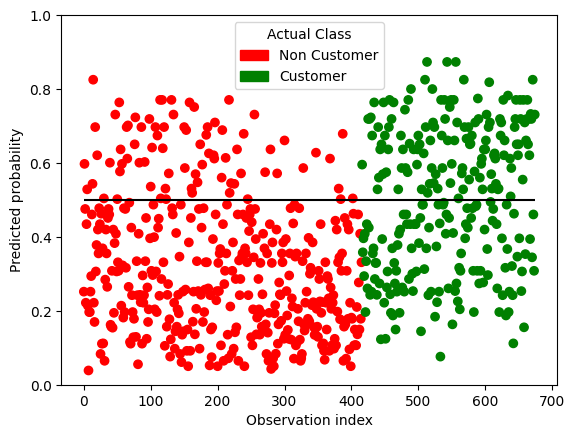

In [7]:
# Create a custom colormap for binary data (0 and 1)
cmap = ListedColormap(['red', 'green'])

# Scatter plot with color based on "y_actual"
scatter = plt.scatter(df_predictions.index, df_predictions["y_pred_probs"], c=df_predictions["y_actual"], cmap=cmap)

# Adding horizontal line
plt.hlines(0.5, 0, max(df_predictions.index), colors="black")

# Customizing the plot
plt.ylim(0, 1)
plt.xlabel("Observation index")
plt.ylabel("Predicted probability")

# Create a custom legend for the binary classes
handles = [mpatches.Patch(color='red', label='Non Customer'), mpatches.Patch(color='green', label='Customer')]
plt.legend(handles=handles, title="Actual Class")

# Display the plot
plt.show()


## Visualize

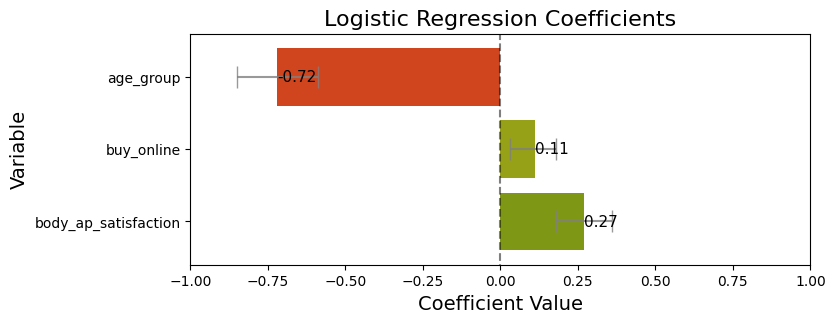

In [8]:
# Set range of x axis
max_val = 1
min_val = - max_val

# Create a custom color map with a range
norm = Normalize(vmin=min_val, vmax=max_val)
cmap=LinearSegmentedColormap.from_list('rg',["r", "y", "g"], N=256) 

# Map coefficients to colors
colors = [cmap(norm(coef)) for coef in df_model['Coefficients']]

# Plot
plt.figure(figsize=(8, 3))
ax = sns.barplot(x='Coefficients', y='Variables', data=df_model, palette=colors, hue='Variables')

# Add value labels on top of each bar
for i, coef in enumerate(df_model['Coefficients']):
    ax.text(coef, i, f'{coef:.2f}', color='black', ha="left", va="center", fontsize=11)

# Add error bars (confidence intervals)
for i, variable in enumerate(df_model['Variables']):
    ci_lower = df_model.loc[df_model['Variables'] == variable, 'CI Lower'].values[0]
    ci_upper = df_model.loc[df_model['Variables'] == variable, 'CI Upper'].values[0]
    ax.errorbar(df_model['Coefficients'][i], i, xerr=[[df_model['Coefficients'][i] - ci_lower], [ci_upper - df_model['Coefficients'][i]]],
                fmt='none', color='grey', capsize=8, alpha=0.8)

# Add labels
plt.title('Logistic Regression Coefficients', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Variable', fontsize=14)
plt.xlim(min_val, max_val)
plt.ylim(-0.6, len(df_model)-0.4)

plt.vlines(0, ymin=-1, ymax=len(df_model)+1, color='black', linestyle='dashed', linewidth=1.5, alpha=0.5)

# Show plot
plt.show()

# Additional analysis - partial correlation

In [9]:
# Compute partial correlation
partial_corr = pg.partial_corr(
    data=df,
    x='buy_online',
    y='Customer_brand_X',
    covar='age_group',
    method='pearson')

# Display result
print("Partial correlation:")
print(partial_corr)

Partial correlation:
           n         r        CI95%     p-val
pearson  675  0.130178  [0.06, 0.2]  0.000705
